# Code for gaze project

> **Keys operations are marked as quotations**


- Task: Build a classifier for the gaze project (Target: S / ~~O~~ / T)


- env: Python 3.7.4

---

- Lyndon, on Jan. 5, 2020
     - 🚩Upload first time on Jan. 8, 2020
         - ~~delete some vars~~
         - [X] interaction term (medium * pid)
         - [X] pcode as dummy var, n pcode columns ~~(if too large, use scode), coder as dummy var~~
         - ~~check if less vars perform good? on previous data~~

---

- Lyndon, on Jan. 11, 2020
    - 🚩Some detailed instructions
        - [X] ~~Standardize all vars except dummy vars, especially the `pose` vars~~ / Change to scaler ([-1, 1]) for `pose_Txxx`, not for all continuous vars (**Q: Is this right or not? I'm not sure**)
        - [X] Create an interaction term: medium * pid
        - [X] Create group mean centered vars for all vars except dummy vars, include group mean and group mean centered vars in the model
        - [X] Delete `coder_result == "O"` in sample
        - [X] Adopt `success` (step I) and `confidence` (step II) as two filters
        - [X] Create dummy vars for `pcode`
        - [X] Give accuracy rate in prediction stage
            - ✅the `predict_proba` method can return probability estimates for the test data

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import preprocessing

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)

In [2]:
data_file = './gaze_project/'
for idx, file_name in enumerate(os.listdir(data_file)):
    print(idx, file_name)

0 openface_7000_coded.csv
1 survey_twoSheets.xlsx
2 .DS_Store
3 openface_7000.csv
4 README.md
5 survey.csv


---
### hadling `survey.csv`
---

In [3]:
survey = pd.read_csv(data_file + os.listdir(data_file)[5], header=0, dtype=str)
survey.head()

,datetime,scode,medium,pcode,gender,race,dev,rid,rnid,rtype,pid,img_a,img_b,q.s_dmn3,q.s_dmn5,q.s_dmn4,q.s_wrm2,q.s_wrm3,q.s_dmn2,q.s_dmn1,q.s_wrm1,q.s_wrm5,q.s_wrm4,q.s_cmp1,q.s_cmp2,q.s_cmp3,q.s_cmp4,q.s_cmp5,q.s_cmp6,s.s_exp,s.o_exp,s.s_pos1,s.s_pos2,s.s_pos3,s.s_ang1,s.s_ang2,s.s_ang3,s.s_sad1,s.s_sad2,s.s_sad3,s.s_anx1,s.s_anx4,s.s_anx5,s.s_anx2,s.s_anx3,s.s_anx6,s.s_prd1,s.s_prd2,s.s_prd3,s.s_prd4,s.s_prd5,s.s_prd6,s.s_prd7,s.s_shm1,s.s_shm2,s.s_shm3,j.f1,j.f2,j.f3,j.i1,j.i2,j.i3,r.d_effc,r.d_engd,r.d_inf1,r.d_inf2,r.d_inf3,r.d_prod,r.o_acc1,r.o_acc2,r.o_acc3,r.o_cmp1,r.o_cmp2,r.o_cmp3,r.o_cmp4,r.o_cmp5,r.o_cmp6,r.o_dmn1,r.o_dmn2,r.o_dmn3,r.o_dmn4,r.o_dmn5,r.o_goal1,r.o_goal2,r.o_wrm1,r.o_wrm2,r.o_wrm3,r.o_wrm4,r.o_wrm5,r.s_acc1,r.s_acc2,r.s_acc3,r.s_ang1,r.s_ang2,r.s_ang3,r.s_anx1,r.s_anx2,r.s_anx3,r.s_anx4,r.s_anx5,r.s_anx6,r.s_pos1,r.s_pos2,r.s_pos3,r.s_prd1,r.s_prd2,r.s_prd3,r.s_prd4,r.s_prd5,r.s_prd6,r.s_prd7,r.s_sad1,r.s_sad2,r.s_sad3,r.s_shm1,r.s_shm2,r.s_shm3,f.qlt,f.prt,f.rlt,f.motv1,f.motv2,f.btr,q.s_dmn,q.s_wrm,q.s_cmp,s.s_pos,s.s_sad,s.s_ang,s.s_anx,s.s_rlx,s.s_prd,s.s_shm,r.o_dmn,r.o_wrm,r.o_cmp,r.s_pos,r.s_sad,r.s_ang,r.s_anx,r.s_rlx,r.s_prd,r.s_shm
0,2018-01-22 14:51:23,ha9i5on2,FTF,ibkv4d1o,F,O,E250,1,NaN,ind,1,e01_bf10.jpg,e01_bf11.jpg,5,4,4,2,7,5,5,4,6,6,-999,-999,-999,-999,-999,-999,0.66,NaN,2.9,1.7,1.3,1.1,1,1,3.8,2,1.5,6.1,6.8,2.8,1,1.6,4,1.5,1.5,2.2,1.8,2.3,1.4,4.6,1.4,1,1.1,NaN,NaN,NaN,1,-0.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0,1,NaN,NaN,NaN,4.6,5,-999,1.96666666666667,2.43333333333333,1.03333333333333,2.2,5.23333333333333,2.18571428571429,1.16666666666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-22 14:51:31,ha9i5on2,FTF,xd1nztr5,F,O,E24D,1,NaN,ind,2,e01_bf10.jpg,e01_bf11.jpg,2,3,2,8,5,4,1,8,5,5,5,4,6,3,3,4,0.7,NaN,4.9,4,4,3,1,4,1.5,3.1,1.2,4,3,6,3,1,2.5,5,5,3.9,5,5.5,4.3,4,2,4,1.1,NaN,NaN,NaN,1,-0.25,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0,1,NaN,NaN,NaN,2.4,6.2,4.16666666666667,4.3,1.93333333333333,2.66666666666667,2.16666666666667,4.33333333333333,4.67142857142857,2.36666666666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-22 14:51:23,ha9i5on2,FTF,ibkv4d1o,F,O,E250,2,NaN,ind,1,e02_wf06.jpg,e02_wf11.jpg,5,4,4,2,7,5,5,4,6,6,-999,-999,-999,-999,-999,-999,0.66,NaN,2.9,1.7,1.3,1.1,1,1,3.8,2,1.5,6.1,6.8,2.8,1,1.6,4,1.5,1.5,2.2,1.8,2.3,1.4,4.6,1.4,1,1.1,NaN,NaN,NaN,-1,-0.5,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0,1,NaN,NaN,NaN,4.6,5,-999,1.96666666666667,2.43333333333333,1.03333333333333,2.2,5.23333333333333,2.18571428571429,1.16666666666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-22 14:51:31,ha9i5on2,FTF,xd1nztr5,F,O,E24D,2,NaN,ind,2,e02_wf06.jpg,e02_wf11.jpg,2,3,2,8,5,4,1,8,5,5,5,4,6,3,3,4,0.7,NaN,4.9,4,4,3,1,4,1.5,3.1,1.2,4,3,6,3,1,2.5,5,5,3.9,5,5.5,4.3,4,2,4,1.1,NaN,NaN,NaN,-1,-0.25,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0,1,NaN,NaN,NaN,2.4,6.2,4.16666666666667,4.3,1.93333333333333,2.66666666666667,2.16666666666667,4.33333333333333,4.67142857142857,2.36666666666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-22 14:51:23,ha9i5on2,FTF,ibkv4d1o,F,O,E250,3,NaN,ind,1,e03_CFD-LM-234-176-N.jpg,e03_CFD-LM-253-075-N.jpg,5,4,4,2,7,5,5,4,6,6,-999,-999,-999,-999,-999,-999,0.66,NaN,2.9,1.7,1.3,1.1,1,1,3.8,2,1.5,6.1,6.8,2.8,1,1.6,4,1.5,1.5,2.2,

In [4]:
print("Number of $pcode is: %s\nNumber of $scode is: %s" %(len(set(list(survey.pcode))), len(set(list(survey.scode)))))

Number of $pcode is: 136
Number of $scode is: 68


In [5]:
survey_new = survey.loc[:, ["scode", "pcode", "medium", "pid"]]
survey_new.shape

(2040, 4)

> Create dummy vars for pcode

In [6]:
survey_new = pd.concat([survey_new, pd.get_dummies(survey_new.pcode)], axis=1, join='inner')
survey_new.shape

(2040, 140)

---
### handling `coded.csv`
---

In [7]:
coded = pd.read_csv(data_file + os.listdir(data_file)[0], header=0, dtype=str)
coded.head()

,scode,pcode,section,tag,section_start,section_end,timestamp,filename,frame,time,face_id,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,coder_sb,coder_yx,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,utt_id,word,word_conf,speaker,speaker_conf,speaker_final
0,0fq8bg05,ot9bx03s,7110,COLL1_1,2018-02-04T19:55:25.000000Z,2018-02-04T19:56:13.000000Z,2018-02-04T19:55:25.014867Z,ot9bx03s_HOSTCAM_2018-02-04_14-37-27.996246_R_...,64680,1077.983,0,0.98,TRUE,0.25279,0.318234,-0.913687,0.05406,0.099144,-0.993604,0.16,0.215,NaN,T,193.7,62.3,500,0.3,-0.49,0.114,0,0,1.86,2.5,0.33,0.5,0.74,0.2,0.25,0,0.01,0,0,0,2.57,1.91,0,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
1,0fq8bg05,ot9bx03s,7110,COLL1_1,2018-02-04T19:55:25.000000Z,2018-02-04T19:56:13.000000Z,2018-02-04T19:55:30.015012Z,ot9bx03s_HOSTCAM_2018-02-04_14-37-27.996246_R_...,64980,1082.983,0,0.98,TRUE,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.95948,0.221,0.289,NaN,T,147.7,25.8,525.4,0.262,-0.395,0.053,0,0,0.48,0.95,0.46,0.16,0.39,0.16,0.64,0,0.01,0,0,0,0.68,0.35,0,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
2,0fq8bg05,ot9bx03s,7110,COLL1_1,2018-02-04T19:55:25.000000Z,2018-02-04T19:56:13.000000Z,2018-02-04T19:55:35.015160Z,ot9bx03s_HOSTCAM_2018-02-04_14-37-27.996246_R_...,65280,1087.983,0,0.98,TRUE,0.28891,0.313157,-0.90469,0.229182,0.230631,-0.945666,0.273,0.286,NaN,T,161.2,34.8,540.5,0.271,-0.44,0.118,0,0,0.84,1.47,0.32,0,0.58,0.14,0.25,0,0,0,0,0,0.57,0.54,0,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
3,0fq8bg05,ot9bx03s,7110,COLL1_1,2018-02-04T19:55:25.000000Z,2018-02-04T19:56:13.000000Z,2018-02-04T19:55:40.015305Z,ot9bx03s_HOSTCAM_2018-02-04_14-37-27.996246_R_...,65580,1092.983,0,0.98,TRUE,0.205453,0.213574,-0.955079,0.128245,0.125417,-0.98378,0.17,0.173,NaN,T,230,39.7,522.5,0.073,-0.517,0.012,0.94,0,2.2,0.11,0.17,1.65,0.72,0.2,0.12,0,0,0.28,0,0,0.94,0.75,0,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN
4,0fq8bg05,ot9bx03s,7110,COLL1_1,2018-02-04T19:55:25.000000Z,2018-02-04T19:56:13.000000Z,2018-02-04T19:55:45.015451Z,ot9bx03s_HOSTCAM_2018-02-04_14-37-27.996246_R_...,65880,1097.983,0,0.98,TRUE,0.441883,0.245742,-0.862757,0.234916,0.191799,-0.952905,0.357,0.236,NaN,T,169.1,29.3,544.6,0.189,-0.517,0.08,0.25,0,0.7,1.26,0.32,0.03,0.46,0,0.2,0,0,0.17,0,0,0,0.69,0,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
coded.shape

(55757, 70)

> Any overlaps?

In [9]:
overlap = coded[coded.coder_sb.notnull() & coded.coder_yx.notnull()]
overlap

,scode,pcode,section,tag,section_start,section_end,timestamp,filename,frame,time,face_id,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,coder_sb,coder_yx,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,utt_id,word,word_conf,speaker,speaker_conf,speaker_final


In [10]:
coded["coder_result"] = coded["coder_sb"].replace(np.NaN, "") + coded["coder_yx"].replace(np.NaN, "")
coded["coder_result"].value_counts()

T    44462
O     6131
S     5164
Name: coder_result, dtype: int64

> drop `coded$coder_result == "O"`

In [11]:
coded = coded[coded['coder_result'] != "O"]
coded.shape

(49626, 71)

> use `success` (step I) and `confidence` (step II) as two filters
>
> set `confidence >= 0.85` as threshold

In [12]:
coded.success.value_counts()

TRUE     47332
FALSE     2294
Name: success, dtype: int64

In [13]:
coded = coded[coded['success'] != "FALSE"]
coded.shape

(47332, 71)

In [14]:
coded["confidence"] = coded["confidence"].astype(float)
for k, v in sorted(dict(coded["confidence"].value_counts()).items(), key=lambda x: x[0], reverse=True):
    print('%s --- %s cases'%(k, v))

0.98 --- 40916 cases
0.95 --- 6 cases
0.92 --- 1711 cases
0.88 --- 3763 cases
0.85 --- 480 cases
0.82 --- 136 cases
0.78 --- 206 cases
0.75 --- 113 cases
0.58 --- 1 cases


In [15]:
coded = coded[coded["confidence"] >= 0.85]
coded.shape

(46876, 71)

In [16]:
coded = coded[["scode", "pcode", 
               "gaze_0_x", "gaze_0_y", "gaze_0_z", "gaze_1_x", "gaze_1_y", "gaze_1_z", "gaze_angle_x", "gaze_angle_y", 
               "pose_Tx", "pose_Ty", "pose_Tz", "pose_Rx", "pose_Ry", "pose_Rz", "coder_result"]]
coded = coded.apply(pd.to_numeric, errors="ignore")
coded.shape

(46876, 17)

> ~~standardize all vars except dummy vars~~ / use scaler to make the feature_range in [-1, 1]
>
> focus on `pose_Tx`, `pose_Ty`, `pose_Tz`

In [17]:
coded.describe()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz
count,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000
mean,0.245944,0.327088,-0.848215,0.093384,0.321183,-0.876790,0.182478,0.356906,-3.998291,-15.954442,540.365217,0.242553,-0.198867,0.016546
std,0.282592,0.164367,0.078646,0.285516,0.177211,0.080250,0.317080,0.188873,80.575405,99.008683,103.497745,0.200864,0.359404,0.176297
min,-0.890098,-0.810388,-0.999984,-0.869178,-0.872128,-0.999995,-1.022000,-1.033000,-445.200000,-420.500000,199.600000,-1.655000,-1.421000,-1.549000
25%,0.026041,0.210728,-0.903844,-0.129758,0.188487,-0.936776,-0.057000,0.220000,-59.900000,-105.000000,474.300000,0.112000,-0.474000,-0.082000
50%,0.328734,0.330172,-0.855683,0.171135,0.318848,-0.894705,0.278000,0.349000,-6.500000,-13.800000,539.400000,0.241000,-0.303000,0.022000
75%,0.458681,0.450013,-0.803348,0.313945,0.464185,-0.829997,0.420000,0.498000,48.600000,74.100000,603.700000,0.370000,0.074000,0.124000
max,0.850763,0.824235,-0.321359,0.801160,0.853380,-0.358412,0.975000,1.034000,756.500000,790.300000,3254.100000,1.702000,1.385000,1.900000


In [18]:
temp = coded[['pose_Tx', 'pose_Ty', 'pose_Tz']]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
min_max_scaler.fit(temp)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [19]:
coded[['pose_Tx', 'pose_Ty', 'pose_Tz']] = min_max_scaler.transform(coded[['pose_Tx', 'pose_Ty', 'pose_Tz']])
coded.head()

,scode,pcode,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,coder_result
0,0fq8bg05,ot9bx03s,0.252790,0.318234,-0.913687,0.054060,0.099144,-0.993604,0.160,0.215,0.063327,-0.202511,-0.803307,0.300,-0.490,0.114,T
1,0fq8bg05,ot9bx03s,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.959480,0.221,0.289,-0.013231,-0.262801,-0.786675,0.262,-0.395,0.053,T
2,0fq8bg05,ot9bx03s,0.288910,0.313157,-0.904690,0.229182,0.230631,-0.945666,0.273,0.286,0.009237,-0.247935,-0.776788,0.271,-0.440,0.118,T
3,0fq8bg05,ot9bx03s,0.205453,0.213574,-0.955079,0.128245,0.125417,-0.983780,0.170,0.173,0.123741,-0.239841,-0.788574,0.073,-0.517,0.012,T
4,0fq8bg05,ot9bx03s,0.441883,0.245742,-0.862757,0.234916,0.191799,-0.952905,0.357,0.236,0.022385,-0.257020,-0.774104,0.189,-0.517,0.080,T


---
### join two dataframes

- `survey_new` & `coded`
---

> key = `pcode`

In [20]:
survey_new_pcode = survey_new.set_index("pcode")
survey_new_pcode = survey_new_pcode.rename(columns={"scode": "scode_right"})

In [21]:
survey_new_pcode.shape

(2040, 139)

In [22]:
survey_new_pcode = survey_new_pcode[~survey_new_pcode.index.duplicated(keep="first")]
survey_new_pcode.shape

(136, 139)

In [23]:
join = coded.join(survey_new_pcode, on="pcode")
join = join.drop("scode_right", axis=1)
join.shape

(46876, 155)

In [24]:
join.coder_result.value_counts()

T    41818
S     5058
Name: coder_result, dtype: int64

> change `medium`, `pid` to dummy vars and generate the interaction term

In [25]:
join = pd.concat([join, pd.get_dummies(join.medium)], axis=1, join='inner')
join = pd.concat([join, pd.get_dummies(join.pid)], axis=1, join='inner')
join['interaction'] = join['AV'] * join['1']
join.shape

(46876, 160)

In [26]:
join['interaction'].value_counts()

0    35536
1    11340
Name: interaction, dtype: int64

In [27]:
join.head()

,scode,pcode,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,coder_result,medium,pid,04oia83a,0z96w8j7,115ua4rf,1jz1x077,1s7tawvo,23m2060t,27u4pl8q,2i89gefd,2p4da6jz,2ttosnm0,33i02bjg,36elpjlu,39jc5cst,39uscwt6,3nmh54im,3pz164o2,3tk8l7ev,4e8mft5w,4jm12jb1,4p5mzims,4v9jax8f,55regxx3,5g5yfumc,5jwi1e4a,5lr1lnbc,5xtczwep,6nhnf318,71anjb7h,7233pnr8,73tzndcf,76b2oxjo,79mpndvb,7ksjevgl,7rtldibp,7zb4wfkg,882oqyip,8he40id8,8v8a9noj,8xdwpxdu,97q3uhk5,9d3yz7oi,9tqu1wml,a60t48rq,akmmz4gv,aus5qjzf,b0l5a8ls,b7kn4097,bagrbnzd,bp1hdqfh,c6mb47kg,cgedxthp,cl7cpx1w,clq4wv8h,copbvxi5,cuu9hihn,cwzdbuaf,d7utbe3z,dg5j3vvx,ev3bxm4z,eynqz3cv,f1a12z5d,fb724p6k,foeruvxa,fx1dfmou,fz24c9uc,gdff30yw,gnqbjnv7,gqjpnot6,h1xph0v3,h6bov1r7,hibppa3d,hre3zzxg,huhd427c,i6uqbwed,ibkv4d1o,j2s9lop9,js6lw7et,k0glvzak,k647xvse,kwg76skd,kxw1e7s0,l00y585w,l7mhg911,lpwrylbc,lrt0dz1o,lu2g8kxm,m5gz5wb2,mi6mdsby,mv8h7sjo,nnh2asyw,nx3p28fc,oa4fv4ev,obsdnoc7,obzij0wr,oh8sy27z,ot9bx03s,owpne6f8,p1tv74la,p31jpwhm,p5ydkr0h,pcodjew9,pee3rrkk,pg5kvnlb,pgviavi3,py7l19yx,qf50mvkd,qgbjtggy,rcjgj3dw,rjcretus,rv9jkr5x,ry5wss0j,s6n1nueo,su9xkl9u,txfmtm1y,u8khb0nf,uh65t7df,ujv7g7kp,utp8mgq7,v3jbmp4s,v6i1nh16,vbzvmqu5,vphovnfw,vu09srb8,wc2jb1i8,wf95avqz,wi4iz3s4,x1rwtpti,xcynizv3,xd1nztr5,xg6r19h1,xw3jrcfn,ylhxti5j,yocf5ddc,z9i3tb69,zhtq8jee,zn75wksr,AV,FTF,1,2,interaction
0,0fq8bg05,ot9bx03s,0.252790,0.318234,-0.913687,0.054060,0.099144,-0.993604,0.160,0.215,0.063327,-0.202511,-0.803307,0.300,-0.490,0.114,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0fq8bg05,ot9bx03s,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.959480,0.221,0.289,-0.013231,-0.262801,-0.786675,0.262,-0.395,0.053,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0fq8bg05,ot9bx03s,0.288910,0.313157,-0.904690,0.229182,0.230631,-0.945666,0.273,0.286,0.009237,-0.247935,-0.776788,0.271,-0.440,0.118,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0fq8bg05,ot9bx03s,0.205453,0.213574,-0.955079,0.128245,0.125417,-0.983780,0.170,0.173,0.123741,-0.239841,-0.788574,0.073,-0.517,0.012,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0fq8bg05,ot9bx03s,0.441883,0.245742,-0.862757,0.234916,0.191799,-0.952905,0.357,0.236,0.022385,-0.257020,-0.774104,0.189,-0.517,0.080,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


> group mean centered for all continuous vars

In [28]:
join = join.set_index(['pcode'])

# group mean
for col_name in join.columns[1: 15]:
    for i in list(set(join.index)):
        join.loc[i, col_name + '_gm'] = join.groupby(by='pcode')[col_name].mean()[i]

# group mean centered
for col_name in join.columns[1: 15]:
    join[col_name + '_gmc'] = join[col_name] - join[col_name + '_gm']

In [29]:
for idx, col_name in enumerate(join.columns[18: 154]):
    join = join.rename(columns={col_name: 'pcode_' + str(idx + 1)})
join.head()

,scode,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,coder_result,medium,pid,pcode_1,pcode_2,pcode_3,pcode_4,pcode_5,pcode_6,pcode_7,pcode_8,pcode_9,pcode_10,pcode_11,pcode_12,pcode_13,pcode_14,pcode_15,pcode_16,pcode_17,pcode_18,pcode_19,pcode_20,pcode_21,pcode_22,pcode_23,pcode_24,pcode_25,pcode_26,pcode_27,pcode_28,pcode_29,pcode_30,pcode_31,pcode_32,pcode_33,pcode_34,pcode_35,pcode_36,pcode_37,pcode_38,pcode_39,pcode_40,pcode_41,pcode_42,pcode_43,pcode_44,pcode_45,pcode_46,pcode_47,pcode_48,pcode_49,pcode_50,pcode_51,pcode_52,pcode_53,pcode_54,pcode_55,pcode_56,pcode_57,pcode_58,pcode_59,pcode_60,pcode_61,pcode_62,pcode_63,pcode_64,pcode_65,pcode_66,pcode_67,pcode_68,pcode_69,pcode_70,pcode_71,pcode_72,pcode_73,pcode_74,pcode_75,pcode_76,pcode_77,pcode_78,pcode_79,pcode_80,pcode_81,pcode_82,pcode_83,pcode_84,pcode_85,pcode_86,pcode_87,pcode_88,pcode_89,pcode_90,pcode_91,pcode_92,pcode_93,pcode_94,pcode_95,pcode_96,pcode_97,pcode_98,pcode_99,pcode_100,pcode_101,pcode_102,pcode_103,pcode_104,pcode_105,pcode_106,pcode_107,pcode_108,pcode_109,pcode_110,pcode_111,pcode_112,pcode_113,pcode_114,pcode_115,pcode_116,pcode_117,pcode_118,pcode_119,pcode_120,pcode_121,pcode_122,pcode_123,pcode_124,pcode_125,pcode_126,pcode_127,pcode_128,pcode_129,pcode_130,pcode_131,pcode_132,pcode_133,pcode_134,pcode_135,pcode_136,AV,FTF,1,2,interaction,gaze_0_x_gm,gaze_0_y_gm,gaze_0_z_gm,gaze_1_x_gm,gaze_1_y_gm,gaze_1_z_gm,gaze_angle_x_gm,gaze_angle_y_gm,pose_Tx_gm,pose_Ty_gm,pose_Tz_gm,pose_Rx_gm,pose_Ry_gm,pose_Rz_gm,gaze_0_x_gmc,gaze_0_y_gmc,gaze_0_z_gmc,gaze_1_x_gmc,gaze_1_y_gmc,gaze_1_z_gmc,gaze_angle_x_gmc,gaze_angle_y_gmc,pose_Tx_gmc,pose_Ty_gmc,pose_Tz_gmc,pose_Rx_gmc,pose_Ry_gmc,pose_Rz_gmc
pcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ot9bx03s,0fq8bg05,0.252790,0.318234,-0.913687,0.054060,0.099144,-0.993604,0.160,0.215,0.063327,-0.202511,-0.803307,0.300,-0.490,0.114,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.368915,0.243781,-0.883389,0.21798,0.198227,-0.944078,0.310651,0.23796,-0.121351,-0.258718,-0.700888,0.146611,-0.47515,0.021243,-0.116125,0.074453,-0.030298,-0.163920,-0.099083,-0.049526,-0.150651,-0.02296,0.184678,0.056207,-0.102419,0.153389,-0.01485,0.092757
ot9bx03s,0fq8bg05,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.959480,0.221,0.289,-0.013231,-0.262801,-0.786675,0.262,-0.395,0.053,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.368915,0.243781,-0.883389,0.21798,0.198227,-0.944078,0.310651,0.23796,-0.121351,-0.258718,-0.700888,0.146611,-0.47515,0.021243,-0.125044,0.092714,-0.026170,-0.041581,0.021502,-0.015402,-0.089651,0.05104,0.108120,-0.004084,-0.085788,0.115389,0.08015,0.031757
ot9bx03s,0fq8bg05,0.288910,0.313157,-0.904690,0.229182,0.230631,-0.945666,0.273,0.286,0.009237,-0.247935,-0.776788,0.271,-0.440,0.118,T,AV,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.368915,0.243781,-0.883389,0.21798,0.198227,-0.944078,0.310651,0.23796,-0.121351,-0.258718,-0.700888,0.146611,-0.47515,0.021243,-0.080005,0.069376,-0.021301,0.011202,0.032404,-0.001588,-0.037651,0.04804,0.130588,0.010783,-0.07

In [30]:
sort_columns = list(join.columns)
sort_columns.sort()
join = join[sort_columns]
join.head()

,1,2,AV,FTF,coder_result,gaze_0_x,gaze_0_x_gm,gaze_0_x_gmc,gaze_0_y,gaze_0_y_gm,gaze_0_y_gmc,gaze_0_z,gaze_0_z_gm,gaze_0_z_gmc,gaze_1_x,gaze_1_x_gm,gaze_1_x_gmc,gaze_1_y,gaze_1_y_gm,gaze_1_y_gmc,gaze_1_z,gaze_1_z_gm,gaze_1_z_gmc,gaze_angle_x,gaze_angle_x_gm,gaze_angle_x_gmc,gaze_angle_y,gaze_angle_y_gm,gaze_angle_y_gmc,interaction,medium,pcode_1,pcode_10,pcode_100,pcode_101,pcode_102,pcode_103,pcode_104,pcode_105,pcode_106,pcode_107,pcode_108,pcode_109,pcode_11,pcode_110,pcode_111,pcode_112,pcode_113,pcode_114,pcode_115,pcode_116,pcode_117,pcode_118,pcode_119,pcode_12,pcode_120,pcode_121,pcode_122,pcode_123,pcode_124,pcode_125,pcode_126,pcode_127,pcode_128,pcode_129,pcode_13,pcode_130,pcode_131,pcode_132,pcode_133,pcode_134,pcode_135,pcode_136,pcode_14,pcode_15,pcode_16,pcode_17,pcode_18,pcode_19,pcode_2,pcode_20,pcode_21,pcode_22,pcode_23,pcode_24,pcode_25,pcode_26,pcode_27,pcode_28,pcode_29,pcode_3,pcode_30,pcode_31,pcode_32,pcode_33,pcode_34,pcode_35,pcode_36,pcode_37,pcode_38,pcode_39,pcode_4,pcode_40,pcode_41,pcode_42,pcode_43,pcode_44,pcode_45,pcode_46,pcode_47,pcode_48,pcode_49,pcode_5,pcode_50,pcode_51,pcode_52,pcode_53,pcode_54,pcode_55,pcode_56,pcode_57,pcode_58,pcode_59,pcode_6,pcode_60,pcode_61,pcode_62,pcode_63,pcode_64,pcode_65,pcode_66,pcode_67,pcode_68,pcode_69,pcode_7,pcode_70,pcode_71,pcode_72,pcode_73,pcode_74,pcode_75,pcode_76,pcode_77,pcode_78,pcode_79,pcode_8,pcode_80,pcode_81,pcode_82,pcode_83,pcode_84,pcode_85,pcode_86,pcode_87,pcode_88,pcode_89,pcode_9,pcode_90,pcode_91,pcode_92,pcode_93,pcode_94,pcode_95,pcode_96,pcode_97,pcode_98,pcode_99,pid,pose_Rx,pose_Rx_gm,pose_Rx_gmc,pose_Ry,pose_Ry_gm,pose_Ry_gmc,pose_Rz,pose_Rz_gm,pose_Rz_gmc,pose_Tx,pose_Tx_gm,pose_Tx_gmc,pose_Ty,pose_Ty_gm,pose_Ty_gmc,pose_Tz,pose_Tz_gm,pose_Tz_gmc,scode
pcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ot9bx03s,0,1,1,0,T,0.252790,0.368915,-0.116125,0.318234,0.243781,0.074453,-0.913687,-0.883389,-0.030298,0.054060,0.21798,-0.163920,0.099144,0.198227,-0.099083,-0.993604,-0.944078,-0.049526,0.160,0.310651,-0.150651,0.215,0.23796,-0.02296,0,AV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.300,0.146611,0.153389,-0.490,-0.47515,-0.01485,0.114,0.021243,0.092757,0.063327,-0.121351,0.184678,-0.202511,-0.258718,0.056207,-0.803307,-0.700888,-0.102419,0fq8bg05
ot9bx03s,0,1,1,0,T,0.243871,0.368915,-0.125044,0.336495,0.243781,0.092714,-0.909559,-0.883389,-0.026170,0.176399,0.21798,-0.041581,0.219729,0.198227,0.021502,-0.959480,-0.944078,-0.015402,0.221,0.310651,-0.089651,0.289,0.23796,0.05104,0,AV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.262,0.146611,0.115389,-0.395,-0.47515,0.08015,0.053,0.021243,0.031757,-0.013231,-0.121351,0.108120,-0.262801,-0.258718,-0.004084,-0.786675,-0.700888,-0.085788,0fq8bg05
ot9bx03s,0,1,1,0,T,0.288910,0.368915,-0.080005,0.313157,0.243781,0.069376,-0.904690,-0.883389,-0.021301,0.229182,0.21798,0.011202,0.230631,0.198227,0.032404,-0.945666,-0.944078,-0.001588,0.273,0.310651,-0.037651,0.286,0.23796,0.04804,0,AV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.271,0.146611,0.124389,-0.440,-0.47515,0.03515,0.118,0.021243,0.096757,0.009237,-0.121351,0.130588,-0.247935,-0.258718,0.010783,-0.77678

In [31]:
join.shape

(46876, 187)

In [32]:
join = join.rename(columns={'1': 'pid_1', '2': 'pid_2', 'AV': 'medium_1', 'FTF': 'medium_2'})
join = join.drop(columns=['medium', 'pid', 'scode', 'pid_2', 'medium_2', 'pcode_1', 
                          'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 
                          'gaze_angle_x', 'gaze_angle_y', 'pose_Rx', 'pose_Ry', 'pose_Rz', 
                          'pose_Tx', 'pose_Ty', 'pose_Tz'], axis=1)
join.shape

(46876, 167)

In [33]:
join = join.rename(columns={'coder_result': 'zzzz_dependent'})
sort_columns = list(join.columns)
sort_columns.sort()
join = join[sort_columns]
join.head()

,gaze_0_x_gm,gaze_0_x_gmc,gaze_0_y_gm,gaze_0_y_gmc,gaze_0_z_gm,gaze_0_z_gmc,gaze_1_x_gm,gaze_1_x_gmc,gaze_1_y_gm,gaze_1_y_gmc,gaze_1_z_gm,gaze_1_z_gmc,gaze_angle_x_gm,gaze_angle_x_gmc,gaze_angle_y_gm,gaze_angle_y_gmc,interaction,medium_1,pcode_10,pcode_100,pcode_101,pcode_102,pcode_103,pcode_104,pcode_105,pcode_106,pcode_107,pcode_108,pcode_109,pcode_11,pcode_110,pcode_111,pcode_112,pcode_113,pcode_114,pcode_115,pcode_116,pcode_117,pcode_118,pcode_119,pcode_12,pcode_120,pcode_121,pcode_122,pcode_123,pcode_124,pcode_125,pcode_126,pcode_127,pcode_128,pcode_129,pcode_13,pcode_130,pcode_131,pcode_132,pcode_133,pcode_134,pcode_135,pcode_136,pcode_14,pcode_15,pcode_16,pcode_17,pcode_18,pcode_19,pcode_2,pcode_20,pcode_21,pcode_22,pcode_23,pcode_24,pcode_25,pcode_26,pcode_27,pcode_28,pcode_29,pcode_3,pcode_30,pcode_31,pcode_32,pcode_33,pcode_34,pcode_35,pcode_36,pcode_37,pcode_38,pcode_39,pcode_4,pcode_40,pcode_41,pcode_42,pcode_43,pcode_44,pcode_45,pcode_46,pcode_47,pcode_48,pcode_49,pcode_5,pcode_50,pcode_51,pcode_52,pcode_53,pcode_54,pcode_55,pcode_56,pcode_57,pcode_58,pcode_59,pcode_6,pcode_60,pcode_61,pcode_62,pcode_63,pcode_64,pcode_65,pcode_66,pcode_67,pcode_68,pcode_69,pcode_7,pcode_70,pcode_71,pcode_72,pcode_73,pcode_74,pcode_75,pcode_76,pcode_77,pcode_78,pcode_79,pcode_8,pcode_80,pcode_81,pcode_82,pcode_83,pcode_84,pcode_85,pcode_86,pcode_87,pcode_88,pcode_89,pcode_9,pcode_90,pcode_91,pcode_92,pcode_93,pcode_94,pcode_95,pcode_96,pcode_97,pcode_98,pcode_99,pid_1,pose_Rx_gm,pose_Rx_gmc,pose_Ry_gm,pose_Ry_gmc,pose_Rz_gm,pose_Rz_gmc,pose_Tx_gm,pose_Tx_gmc,pose_Ty_gm,pose_Ty_gmc,pose_Tz_gm,pose_Tz_gmc,zzzz_dependent
pcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ot9bx03s,0.368915,-0.116125,0.243781,0.074453,-0.883389,-0.030298,0.21798,-0.163920,0.198227,-0.099083,-0.944078,-0.049526,0.310651,-0.150651,0.23796,-0.02296,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.146611,0.153389,-0.47515,-0.01485,0.021243,0.092757,-0.121351,0.184678,-0.258718,0.056207,-0.700888,-0.102419,T
ot9bx03s,0.368915,-0.125044,0.243781,0.092714,-0.883389,-0.026170,0.21798,-0.041581,0.198227,0.021502,-0.944078,-0.015402,0.310651,-0.089651,0.23796,0.05104,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.146611,0.115389,-0.47515,0.08015,0.021243,0.031757,-0.121351,0.108120,-0.258718,-0.004084,-0.700888,-0.085788,T
ot9bx03s,0.368915,-0.080005,0.243781,0.069376,-0.883389,-0.021301,0.21798,0.011202,0.198227,0.032404,-0.944078,-0.001588,0.310651,-0.037651,0.23796,0.04804,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.146611,0.124389,-0.47515,0.03515,0.021243,0.096757,-0.121351,0.130588,-0.258718,0.010783,-0.700888,-0.075900,T
ot9bx03s,0.368915,-0.163462,0.243781,-0.030207,-0.883389,-0.071690,0.21798,-0.089735,0.198227,-0.072810,-0.944078,-0.039702,0.310651,-0.140651,0.23796,-0.06496,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.146611,-0.073611,-0.47515,-0.04185,0.021243,-0.009243,-0.121351,0.245093,-0.258718,0.018876,-0.700888,-0.08

### new classifier on Jan. 11, 2020

In [34]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier

In [35]:
join = join.apply(pd.to_numeric, errors='ignore')
join.describe()

,gaze_0_x_gm,gaze_0_x_gmc,gaze_0_y_gm,gaze_0_y_gmc,gaze_0_z_gm,gaze_0_z_gmc,gaze_1_x_gm,gaze_1_x_gmc,gaze_1_y_gm,gaze_1_y_gmc,gaze_1_z_gm,gaze_1_z_gmc,gaze_angle_x_gm,gaze_angle_x_gmc,gaze_angle_y_gm,gaze_angle_y_gmc,interaction,medium_1,pcode_10,pcode_100,pcode_101,pcode_102,pcode_103,pcode_104,pcode_105,pcode_106,pcode_107,pcode_108,pcode_109,pcode_11,pcode_110,pcode_111,pcode_112,pcode_113,pcode_114,pcode_115,pcode_116,pcode_117,pcode_118,pcode_119,pcode_12,pcode_120,pcode_121,pcode_122,pcode_123,pcode_124,pcode_125,pcode_126,pcode_127,pcode_128,pcode_129,pcode_13,pcode_130,pcode_131,pcode_132,pcode_133,pcode_134,pcode_135,pcode_136,pcode_14,pcode_15,pcode_16,pcode_17,pcode_18,pcode_19,pcode_2,pcode_20,pcode_21,pcode_22,pcode_23,pcode_24,pcode_25,pcode_26,pcode_27,pcode_28,pcode_29,pcode_3,pcode_30,pcode_31,pcode_32,pcode_33,pcode_34,pcode_35,pcode_36,pcode_37,pcode_38,pcode_39,pcode_4,pcode_40,pcode_41,pcode_42,pcode_43,pcode_44,pcode_45,pcode_46,pcode_47,pcode_48,pcode_49,pcode_5,pcode_50,pcode_51,pcode_52,pcode_53,pcode_54,pcode_55,pcode_56,pcode_57,pcode_58,pcode_59,pcode_6,pcode_60,pcode_61,pcode_62,pcode_63,pcode_64,pcode_65,pcode_66,pcode_67,pcode_68,pcode_69,pcode_7,pcode_70,pcode_71,pcode_72,pcode_73,pcode_74,pcode_75,pcode_76,pcode_77,pcode_78,pcode_79,pcode_8,pcode_80,pcode_81,pcode_82,pcode_83,pcode_84,pcode_85,pcode_86,pcode_87,pcode_88,pcode_89,pcode_9,pcode_90,pcode_91,pcode_92,pcode_93,pcode_94,pcode_95,pcode_96,pcode_97,pcode_98,pcode_99,pid_1,pose_Rx_gm,pose_Rx_gmc,pose_Ry_gm,pose_Ry_gmc,pose_Rz_gm,pose_Rz_gmc,pose_Tx_gm,pose_Tx_gmc,pose_Ty_gm,pose_Ty_gmc,pose_Tz_gm,pose_Tz_gmc
count,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.0,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.0,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.0,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04,46876.000000,4.687600e+04
mean,0.245944,3.980346e-17,0.327088,6.231919e-18,-0.848215,-3.507638e-18,0.093384,-9.852649e-18,0.321183,5.260273e-18,-0.876790,-1.980714e-17,0.182478,1.694135e-17,0.356906,4.361337e-17,0.241915,0.483915,0.008042,0.007893,0.0

In [36]:
array = join.values
X = array[:, 0: -1].astype(float)
Y = array[:, -1]
validation_size = 0.2
seed = 111
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [37]:
print('%s size: %s\n%s size: %s'%('Training set', len(X_train), 'Validation set', len(X_validation)))

Training set size: 37500
Validation set size: 9376


In [38]:
num_folds = 10
seed = 111
scoring = 'accuracy'

models = dict()
models['LR'] = LogisticRegression()
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
results = list()

In [39]:
%%time
for key in models:
    kFold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(models[key], X_train, Y_train, n_jobs=-1, cv=kFold, scoring=scoring)
    results.append(cv_results)
    print('%s: %f (%f)'%(key, cv_results.mean(), cv_results.std()))

LR: 0.929493 (0.004013)
LDA: 0.929173 (0.004034)
KNN: 0.973813 (0.001796)
CART: 0.961600 (0.003207)
NB: 0.581680 (0.012899)
CPU times: user 426 ms, sys: 398 ms, total: 825 ms
Wall time: 47.7 s


In [40]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X=X_train, y=Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions), '\n', classification_report(Y_validation, predictions))
# print(confusion_matrix(Y_validation, predictions), '\n')

0.9770691126279863 
               precision    recall  f1-score   support

           S       0.91      0.87      0.89       982
           T       0.98      0.99      0.99      8394

    accuracy                           0.98      9376
   macro avg       0.95      0.93      0.94      9376
weighted avg       0.98      0.98      0.98      9376



---
### SKIP: build classifier using scikit-learn

> ⚠️ the following code belongs to old version, please skip this part

---

In [33]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

#### pre-processing

In [34]:
join = join.apply(pd.to_numeric, errors='ignore')
join.describe()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,pid
count,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000,52214.000000
mean,0.240513,0.332469,-0.848593,0.084407,0.326242,-0.876549,0.174906,0.362136,-4.833313,-16.115595,541.279984,0.245102,-0.190158,0.017520,1.499138
std,0.278610,0.166130,0.079297,0.282505,0.178177,0.080927,0.313014,0.190002,81.512024,99.590353,105.187131,0.204457,0.356300,0.179493,0.500004
min,-0.890098,-0.810388,-0.999984,-0.869178,-0.872128,-0.999995,-1.022000,-1.033000,-445.200000,-432.400000,199.600000,-1.655000,-1.421000,-1.549000,1.000000
25%,0.029378,0.214853,-0.905067,-0.136965,0.192660,-0.937080,-0.059000,0.225000,-60.800000,-105.200000,474.500000,0.112000,-0.466000,-0.082000,1.000000
50%,0.316086,0.336377,-0.856155,0.154147,0.325271,-0.894510,0.261000,0.355000,-7.150000,-14.900000,540.700000,0.243000,-0.285000,0.023000,1.000000
75%,0.451768,0.456071,-0.803023,0.306076,0.468470,-0.829392,0.412000,0.503000,48.100000,74.600000,604.500000,0.375000,0.078000,0.125000,2.000000
max,0.850763,0.824235,-0.321359,0.870328,0.889581,-0.092029,1.076000,1.034000,756.500000,790.300000,3254.100000,1.702000,1.385000,1.900000,2.000000


In [35]:
print(join.dtypes)

scode            object
pcode            object
gaze_0_x        float64
gaze_0_y        float64
gaze_0_z        float64
gaze_1_x        float64
gaze_1_y        float64
gaze_1_z        float64
gaze_angle_x    float64
gaze_angle_y    float64
pose_Tx         float64
pose_Ty         float64
pose_Tz         float64
pose_Rx         float64
pose_Ry         float64
pose_Rz         float64
coder_result     object
medium           object
pid               int64
dtype: object


In [36]:
join = join[['gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 
             'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz', 
             'pose_Rx', 'pose_Ry', 'pose_Rz', 'coder_result', 
             'medium', 'pid', 'scode', 'pcode']]

gaze_0_x


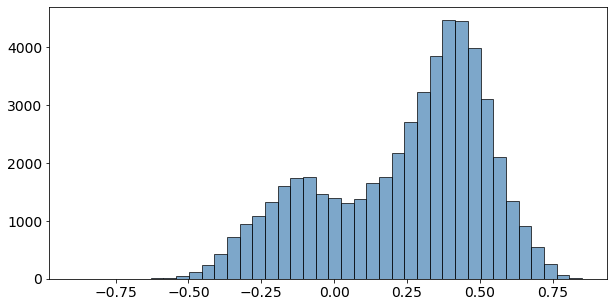

gaze_0_y


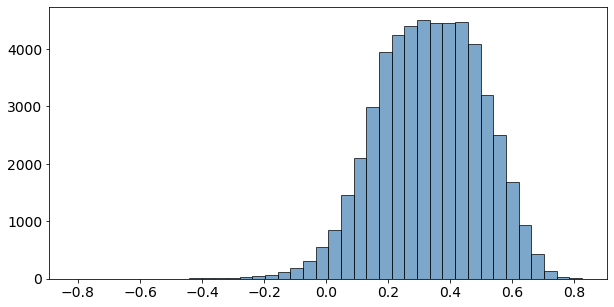

gaze_0_z


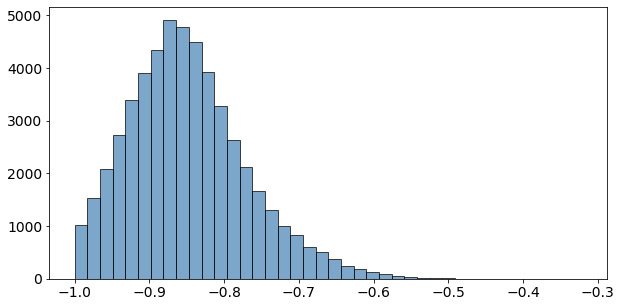

gaze_1_x


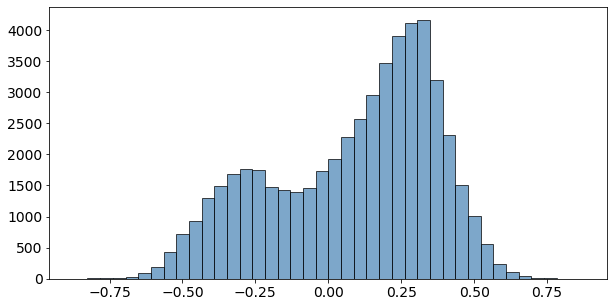

gaze_1_y


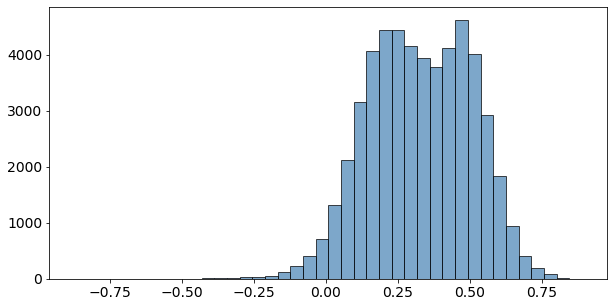

gaze_1_z


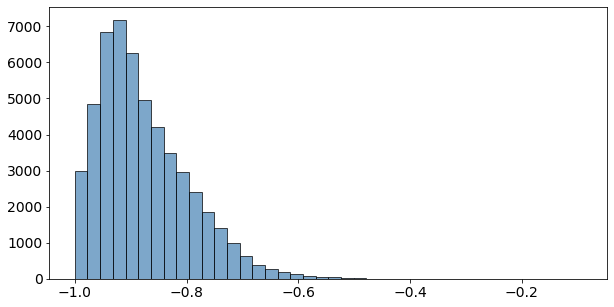

gaze_angle_x


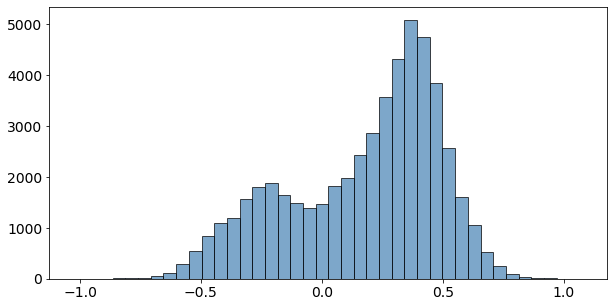

gaze_angle_y


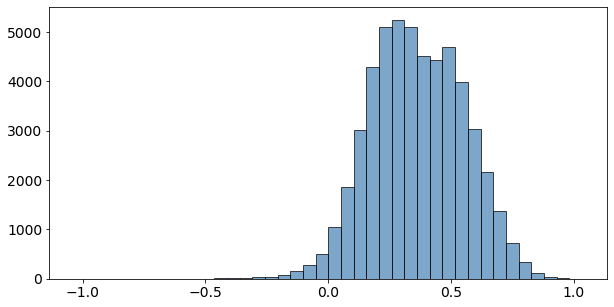

pose_Tx


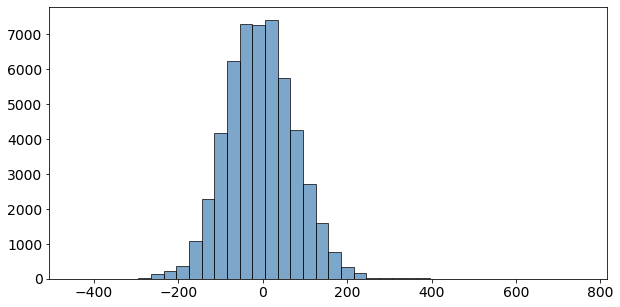

pose_Ty


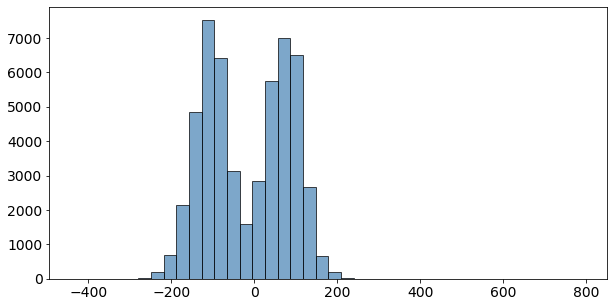

pose_Tz


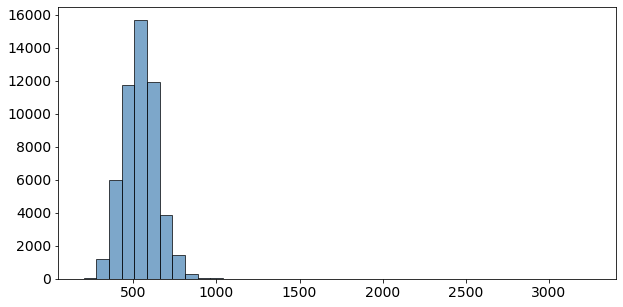

pose_Rx


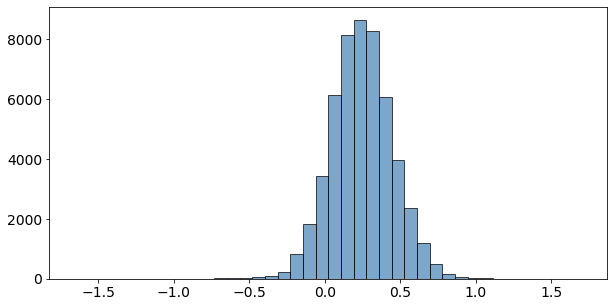

pose_Ry


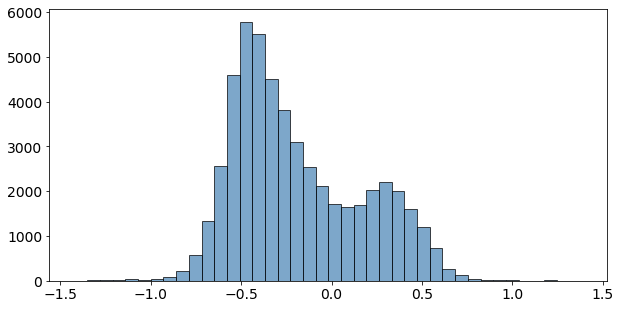

pose_Rz


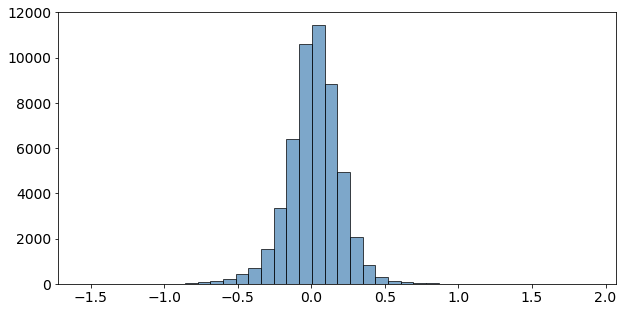

In [37]:
# check the distribution
fields = list(join.columns)
plt.rcParams['font.size'] = 14
for idx in range(1, 15):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(join.iloc[:, idx-1], 
             bins=40, 
             facecolor='steelblue', 
             edgecolor='black', 
             alpha=0.7)
    print(fields[idx - 1])
    plt.show()

In [38]:
join['medium'].value_counts()

FTF    27050
AV     25164
Name: medium, dtype: int64

In [39]:
# transform medium field into binary
# AV = 0, FTF = 1
join.loc[join['medium'] == 'AV', 'medium'] = 0
join.loc[join['medium'] == 'FTF', 'medium'] = 1
join.head()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,coder_result,medium,pid,scode,pcode
0,0.252790,0.318234,-0.913687,0.054060,0.099144,-0.993604,0.160,0.215,193.7,62.3,500.0,0.300,-0.490,0.114,T,0,2,0fq8bg05,ot9bx03s
1,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.959480,0.221,0.289,147.7,25.8,525.4,0.262,-0.395,0.053,T,0,2,0fq8bg05,ot9bx03s
2,0.288910,0.313157,-0.904690,0.229182,0.230631,-0.945666,0.273,0.286,161.2,34.8,540.5,0.271,-0.440,0.118,T,0,2,0fq8bg05,ot9bx03s
3,0.205453,0.213574,-0.955079,0.128245,0.125417,-0.983780,0.170,0.173,230.0,39.7,522.5,0.073,-0.517,0.012,T,0,2,0fq8bg05,ot9bx03s
4,0.441883,0.245742,-0.862757,0.234916,0.191799,-0.952905,0.357,0.236,169.1,29.3,544.6,0.189,-0.517,0.080,T,0,2,0fq8bg05,ot9bx03s


In [40]:
join['medium'].value_counts()

1    27050
0    25164
Name: medium, dtype: int64

In [41]:
join['pid'].value_counts()

1    26152
2    26062
Name: pid, dtype: int64

In [42]:
# transform pid field into binary
# 1 = 0, 2 = 1
join.loc[join['pid'] == 1, 'pid'] = 0
join.loc[join['pid'] == 2, 'pid'] = 1
join.head()

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,coder_result,medium,pid,scode,pcode
0,0.252790,0.318234,-0.913687,0.054060,0.099144,-0.993604,0.160,0.215,193.7,62.3,500.0,0.300,-0.490,0.114,T,0,1,0fq8bg05,ot9bx03s
1,0.243871,0.336495,-0.909559,0.176399,0.219729,-0.959480,0.221,0.289,147.7,25.8,525.4,0.262,-0.395,0.053,T,0,1,0fq8bg05,ot9bx03s
2,0.288910,0.313157,-0.904690,0.229182,0.230631,-0.945666,0.273,0.286,161.2,34.8,540.5,0.271,-0.440,0.118,T,0,1,0fq8bg05,ot9bx03s
3,0.205453,0.213574,-0.955079,0.128245,0.125417,-0.983780,0.170,0.173,230.0,39.7,522.5,0.073,-0.517,0.012,T,0,1,0fq8bg05,ot9bx03s
4,0.441883,0.245742,-0.862757,0.234916,0.191799,-0.952905,0.357,0.236,169.1,29.3,544.6,0.189,-0.517,0.080,T,0,1,0fq8bg05,ot9bx03s


In [43]:
join['pid'].value_counts()

0    26152
1    26062
Name: pid, dtype: int64

In [44]:
print(len(list(set(list(join['scode'])))))
print(len(list(set(list(join['pcode'])))))

67
133


In [45]:
join = join[['gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 
             'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz', 
             'pose_Rx', 'pose_Ry', 'pose_Rz', 'medium', 'pid', 'coder_result']]

In [46]:
# separate dataset
array = join.values
X = array[:, 0:16].astype(float)
Y = array[:, 16]
validation_size = 0.2
seed = 106
X_train, X_validation, Y_train, Y_validation = train_test_split(X, 
                                                                Y, 
                                                                test_size=validation_size, 
                                                                random_state=seed)

In [68]:
print('%s size: %s'%('Training set', len(X_train)))
print('%s size: %s'%('Validation set', len(X_validation)))

Training set size: 41771
Validation set size: 10443


#### import raw data

In [47]:
# evaluate algorithm
num_folds = 10
seed = 106
scoring = 'accuracy'

In [48]:
models = dict()
models['LR'] = LogisticRegression()
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
# models['SVM'] = SVC()
results = list()

In [49]:
for key in models:
    kFold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(models[key], 
                                 X_train, 
                                 Y_train, 
                                 n_jobs=-1, 
                                 cv=kFold, 
                                 scoring=scoring)
    results.append(cv_results)
    print('%s: %f (%f)'%(key, cv_results.mean(), cv_results.std()))

LR: 0.813746 (0.006267)
LDA: 0.815949 (0.004692)
KNN: 0.787269 (0.004795)
CART: 0.844892 (0.004058)
NB: 0.725551 (0.008805)


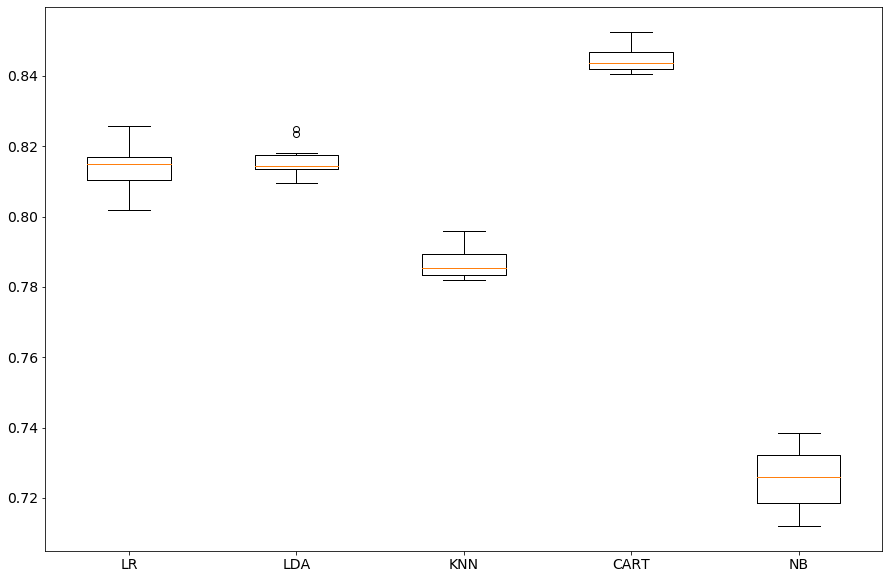

In [50]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()

In [65]:
# try the CART with raw data, although unscientific
model = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 
              'splitter': ['best', 'random'], 
              'max_features': [None, 'auto', 'sqrt', 'log2']}
kfold = KFold(n_splits=num_folds, 
              random_state=seed)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring=scoring, 
                    cv=kfold)
grid_result = grid.fit(X=X_train, 
                       y=Y_train)

print('Best score: %s using: %s'%(grid_result.best_score_, 
                                  grid_result.best_params_))

cv_results = zip(grid_result.cv_results_['mean_test_score'], 
                 grid_result.cv_results_['std_test_score'], 
                 grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r'%(mean, std, param))

Best score: 0.848555217734792 using: {'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}
0.844653 (0.004356) with {'criterion': 'gini', 'max_features': None, 'splitter': 'best'}
0.841613 (0.003209) with {'criterion': 'gini', 'max_features': None, 'splitter': 'random'}
0.836322 (0.005078) with {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'}
0.829307 (0.005893) with {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'random'}
0.834287 (0.007345) with {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}
0.827488 (0.007567) with {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}
0.831917 (0.005218) with {'criterion': 'gini', 'max_features': 'log2', 'splitter': 'best'}
0.823945 (0.007479) with {'criterion': 'gini', 'max_features': 'log2', 'splitter': 'random'}
0.848555 (0.005353) with {'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}
0.846089 (0.005971) with {'criterion': 'entropy', 'max_features': None, 

In [66]:
model = DecisionTreeClassifier(criterion='entropy', 
                               splitter='best', 
                               max_features=None)
model.fit(X=X_train, 
          y=Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [67]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions), '\n' * 2)
print(confusion_matrix(Y_validation, predictions), '\n' * 2)
print(classification_report(Y_validation, predictions))

# comments
# T的变动范围小于S和O
# 计算方差

0.8457339844872164 


[[ 439  158  486]
 [ 159  692  146]
 [ 495  167 7701]] 


              precision    recall  f1-score   support

           O       0.40      0.41      0.40      1083
           S       0.68      0.69      0.69       997
           T       0.92      0.92      0.92      8363

    accuracy                           0.85     10443
   macro avg       0.67      0.67      0.67     10443
weighted avg       0.85      0.85      0.85     10443



#### import standardized data

In [51]:
pipelines = dict()
pipelines['ScalerLR'] = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])
pipelines['ScalerLDA'] = Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])
pipelines['ScalerKNN'] = Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])
pipelines['ScalerCART'] = Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])
pipelines['ScalerNB'] = Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])
results = list()

In [52]:
for key in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(pipelines[key], 
                                 X_train, 
                                 Y_train, 
                                 cv=kfold, 
                                 scoring=scoring)
    results.append(cv_results)
    print('%s: %f (%f)'%(key, cv_results.mean(), cv_results.std()))

ScalerLR: 0.821048 (0.004237)
ScalerLDA: 0.815949 (0.004692)
ScalerKNN: 0.899955 (0.004673)
ScalerCART: 0.844485 (0.004753)
ScalerNB: 0.725384 (0.008715)


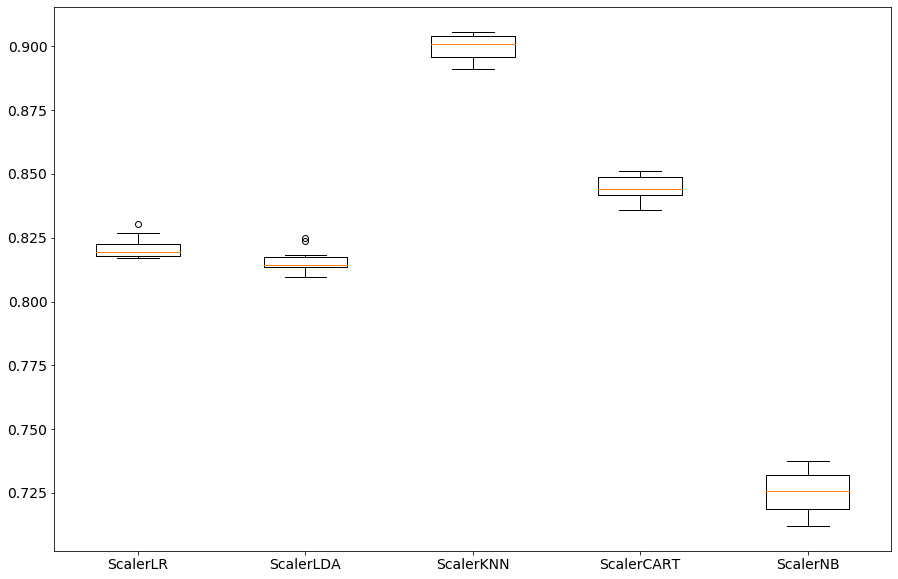

In [53]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(pipelines.keys())
plt.show()

#### improve algorithm

In [54]:
# adjust parameters for KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 
              'weights': ['uniform', 'distance']}
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, 
              random_state=seed)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring=scoring, 
                    cv=kfold)
grid_result = grid.fit(X=rescaledX, 
                       y=Y_train)

print('Best score: %s using: %s'%(grid_result.best_score_, 
                                  grid_result.best_params_))

cv_results = zip(grid_result.cv_results_['mean_test_score'], 
                 grid_result.cv_results_['std_test_score'], 
                 grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r'%(mean, std, param))

Best score: 0.9014866773598909 using: {'n_neighbors': 5, 'weights': 'distance'}
0.883196 (0.006683) with {'n_neighbors': 1, 'weights': 'uniform'}
0.883196 (0.006683) with {'n_neighbors': 1, 'weights': 'distance'}
0.897345 (0.003763) with {'n_neighbors': 3, 'weights': 'uniform'}
0.898087 (0.004830) with {'n_neighbors': 3, 'weights': 'distance'}
0.899907 (0.004631) with {'n_neighbors': 5, 'weights': 'uniform'}
0.901487 (0.004643) with {'n_neighbors': 5, 'weights': 'distance'}
0.899428 (0.005185) with {'n_neighbors': 7, 'weights': 'uniform'}
0.901223 (0.004779) with {'n_neighbors': 7, 'weights': 'distance'}
0.898949 (0.005277) with {'n_neighbors': 9, 'weights': 'uniform'}
0.900840 (0.005141) with {'n_neighbors': 9, 'weights': 'distance'}
0.898039 (0.004600) with {'n_neighbors': 11, 'weights': 'uniform'}
0.899811 (0.004583) with {'n_neighbors': 11, 'weights': 'distance'}
0.896603 (0.004959) with {'n_neighbors': 13, 'weights': 'uniform'}
0.898303 (0.004440) with {'n_neighbors': 13, 'weights

In [55]:
# final model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = KNeighborsClassifier(n_neighbors=5, 
                             weights='distance', 
                             n_jobs=-1)
model.fit(X=rescaledX, 
          y=Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')

In [56]:
# evaluate model
rescaled_validationX = scaler.transform(X_validation)
predictions = model.predict(rescaled_validationX)
print(accuracy_score(Y_validation, predictions), '\n' * 2)
print(confusion_matrix(Y_validation, predictions), '\n' * 2)
print(classification_report(Y_validation, predictions))

0.90165661208465 


[[ 365  157  561]
 [  45  854   98]
 [  84   82 8197]] 


              precision    recall  f1-score   support

           O       0.74      0.34      0.46      1083
           S       0.78      0.86      0.82       997
           T       0.93      0.98      0.95      8363

    accuracy                           0.90     10443
   macro avg       0.82      0.72      0.74     10443
weighted avg       0.89      0.90      0.89     10443



- Precision = TP / (TP + FP), base: dataset


- recall = TP / (TP + FN), base: prediction


- F1: Harmonic mean of Precision & Recall

In [57]:
%%html
<img src='Fig 1.png', width=800, height=800>

#### ensemble algorithms

In [58]:
ensembles = dict()
ensembles['ScaledAB'] = Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostClassifier())])
ensembles['ScaledGBM'] = Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingClassifier())])
ensembles['ScaledRF'] = Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])
ensembles['ScaledET'] = Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesClassifier())])
results = list()

In [59]:
for key in ensembles:
    kfold = KFold(n_splits=num_folds, 
                  random_state=seed)
    cv_result = cross_val_score(ensembles[key], 
                                X_train, 
                                Y_train, 
                                cv=kfold, 
                                scoring=scoring)
    results.append(cv_result)
    print('%s: %f (%f)'%(key, cv_result.mean(), cv_result.std()))

ScaledAB: 0.816093 (0.007290)
ScaledGBM: 0.865289 (0.005457)
ScaledRF: 0.891528 (0.003893)
ScaledET: 0.894520 (0.004980)


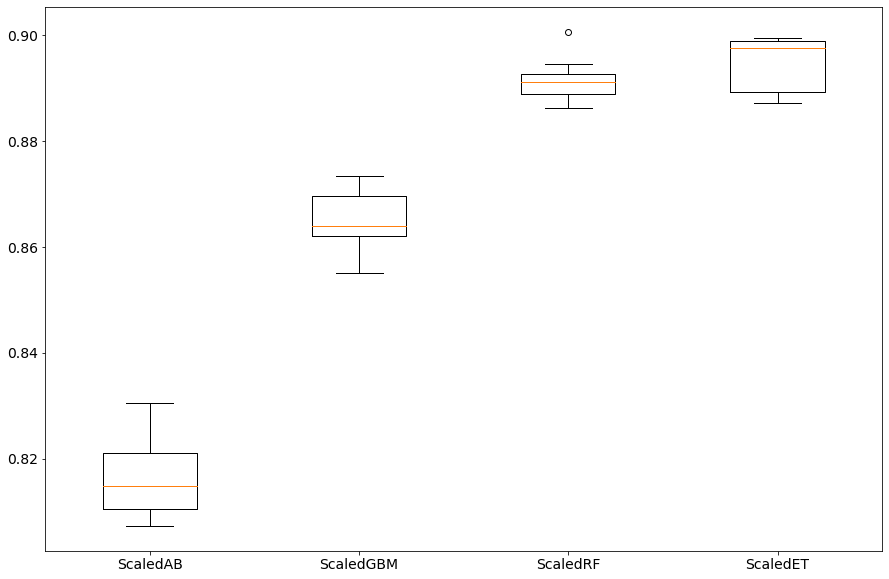

In [61]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ensembles.keys())
plt.show()

In [62]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'max_features': ['auto', 'sqrt', 'log2']}
model = ExtraTreesClassifier()
kfold = KFold(n_splits=num_folds, 
              random_state=seed)
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    scoring=scoring, 
                    cv=kfold, 
                    n_jobs=-1)
grid_result = grid.fit(X=rescaledX, 
                       y=Y_train)
print('Best score: %s using: %s'%(grid_result.best_score_, 
                                  grid_result.best_params_))

Best score: 0.8952622632927151 using: {'max_features': 'sqrt'}


In [63]:
# final model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesClassifier(max_features='sqrt',  
                             n_jobs=-1)
model.fit(X=rescaledX, 
          y=Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [64]:
# evaluate model
rescaled_validationX = scaler.transform(X_validation)
predictions = model.predict(rescaled_validationX)
print(accuracy_score(Y_validation, predictions), '\n' * 2)
print(confusion_matrix(Y_validation, predictions), '\n' * 2)
print(classification_report(Y_validation, predictions))

0.8935171885473523 


[[ 386  136  561]
 [  72  796  129]
 [ 127   87 8149]] 


              precision    recall  f1-score   support

           O       0.66      0.36      0.46      1083
           S       0.78      0.80      0.79       997
           T       0.92      0.97      0.95      8363

    accuracy                           0.89     10443
   macro avg       0.79      0.71      0.73     10443
weighted avg       0.88      0.89      0.88     10443

